In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.multioutput import MultiOutputClassifier 
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [31]:
X = pd.read_csv('data/training_set_features.csv')
y = pd.read_csv('data/training_set_labels.csv')

In [32]:
data = pd.concat([X,y], axis = 1)
data = data.drop('respondent_id', axis = 1)

In [33]:
data.shape

(26707, 37)

In [34]:
data.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

## Baseline Model
To get a baseline, we will use a logistic regression model. We will OneHotEncode all of the data and will fill missing values with the mode.

In [35]:
X = X.drop('respondent_id', axis = 1)
y = y.drop('respondent_id', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

In [36]:
X_train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
4727,3.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,Below Poverty,Married,Own,Employed,kbazzjca,Non-MSA,2.0,0.0,fcxhlnwr,vlluhbov
22245,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,1.0,NaN,NaN
7895,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,lzgpxyit,"MSA, Not Principle City",1.0,0.0,NaN,NaN
6338,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,bhuqouqj,Non-MSA,0.0,0.0,wxleyezf,emcorrxb
16995,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,kbazzjca,Non-MSA,0.0,0.0,NaN,NaN


In [37]:
baseline_imputer = SimpleImputer(strategy = 'most_frequent')
X_train = pd.DataFrame(baseline_imputer.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(baseline_imputer.transform(X_test), columns = X_test.columns)

In [38]:
dummies = OneHotEncoder(drop = 'first', sparse = False)
X_train = pd.DataFrame(dummies.fit_transform(X_train), columns = dummies.get_feature_names())
X_test = pd.DataFrame(dummies.transform(X_test), columns = dummies.get_feature_names())

In [39]:
y_train

,h1n1_vaccine,seasonal_vaccine
4727,0,1
22245,0,0
7895,0,0
6338,0,0
16995,1,1
...,...,...
21480,0,0
330,0,0
11350,0,0
5453,0,0


In [40]:
baseline_model = MultiOutputClassifier(LogisticRegression(max_iter = 1000))
baseline_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000))

In [41]:
preds = baseline_model.predict_proba(X_test)
h1n1_preds = preds[0][:,1]
seasonal_preds = preds[1][:,1]

In [42]:
y_h1n1 = np.array(y_test.iloc[:,0])
y_seasonal = np.array(y_test.iloc[:,1])

In [43]:
h1n1_fpr, h1n1_tpr, h1n1_thresholds = roc_curve(y_h1n1, h1n1_preds)
baseline_h1n1_auc = auc(h1n1_fpr, h1n1_tpr)
sea_fpr, sea_tpr, sea_thresholds = roc_curve(y_seasonal, seasonal_preds)
baseline_sea_auc = auc(sea_fpr, sea_tpr)


In [44]:
def get_threshold(fpr,tpr, threshold):
    youdenJ = tpr - fpr
    index = np.argmax(youdenJ)
    return threshold[index]

C:\Users\talan\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass fpr=[0.         0.         0.         ... 0.99968479 0.99968479 1.        ], tpr=[0.00000000e+00 5.99520384e-04 1.01918465e-02 ... 9.99400480e-01
 1.00000000e+00 1.00000000e+00] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


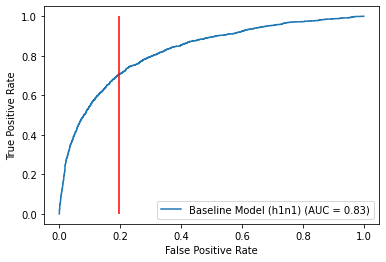

C:\Users\talan\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass fpr=[0.         0.         0.         ... 0.99494369 0.99494369 1.        ], tpr=[0.00000000e+00 2.73074823e-04 5.46149645e-03 ... 9.99726925e-01
 1.00000000e+00 1.00000000e+00] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Optimal Threshold: 0.195702731003921


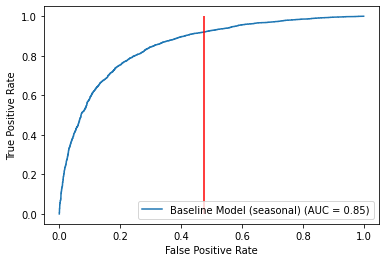

Optimal Threshold: 0.47679644157058587


In [45]:
display = RocCurveDisplay(h1n1_fpr, h1n1_tpr, roc_auc = baseline_h1n1_auc,estimator_name = 'Baseline Model (h1n1)')
optimal_h1n1_threshold = get_threshold(h1n1_fpr, h1n1_tpr, h1n1_thresholds)
display.plot()
plt.vlines(optimal_h1n1_threshold, 0, 1, colors = 'red')
plt.show()
print('Optimal Threshold: {}'.format(optimal_h1n1_threshold))


display = RocCurveDisplay(sea_fpr, sea_tpr, roc_auc = baseline_sea_auc,estimator_name = 'Baseline Model (seasonal)')
optimal_seasonal_threshold = get_threshold(sea_fpr, sea_tpr, sea_thresholds)
display.plot()
plt.vlines(optimal_seasonal_threshold, 0, 1, colors = 'red')
plt.show()
print('Optimal Threshold: {}'.format(optimal_seasonal_threshold))


## Getting first predictions

In [46]:
baseline_imputer = SimpleImputer(strategy = 'most_frequent')
dummies = OneHotEncoder(drop = 'first', sparse = False)
X = baseline_imputer.fit_transform(X)
X = dummies.fit_transform(X)

In [47]:
X_test = pd.read_csv('data/test_set_features.csv')
ids = X_test['respondent_id']
X_test = X_test.drop('respondent_id', axis = 1)
X_test = baseline_imputer.transform(X_test)
X_test = dummies.transform(X_test)

In [48]:
baseline_model.fit(X,y)
preds = baseline_model.predict_proba(X_test)

In [57]:
h1n1_preds = preds[0][:,1]
seasonal_preds = preds[1][:,1]
array_preds = np.transpose([h1n1_preds, seasonal_preds])

In [60]:
predictions = pd.DataFrame(array_preds, columns = ['h1n1_vaccine', 'seasonal_vaccine'], index = ids)

In [64]:
predictions.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.060103,0.319116
26708,0.035129,0.034420
26709,0.415765,0.708950
26710,0.428446,0.845424
26711,0.191677,0.355653


In [24]:
#predictions['h1n1_vaccine'] = (predictions['h1n1_vaccine'] > optimal_h1n1_threshold).astype(int)
#predictions['seasonal_vaccine'] = (predictions['seasonal_vaccine'] > optimal_seasonal_threshold).astype(int)

In [25]:
#predictions.head()

In [26]:
predictions.to_csv('predictions/baseline_preds.csv')